# Bandit Sequence Design

Design 60 6-base RBS sequences based on the bandit recommendations.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict
from sklearn.manifold import TSNE
#import seaborn as sns
from itertools import product
import math

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import Regression
from codes.kernels import spectrum_kernel
from codes.kernels_pairwise import spectrum_kernel_pw, sum_spectrum_kernel_pw, mixed_spectrum_kernel_pw, WD_kernel_pw, WD_shift_kernel_pw

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

## Reading Dataset

In [2]:
# Data downloaded from https://github.com/synbiochem/opt-mva
# Paper https://pubs.acs.org/doi/abs/10.1021/acssynbio.8b00398

Path = '../data/RBS_seqs.csv'

df = pd.read_csv(Path)
df.columns = ['A', 'B', 'C']
df['D'] = df['B'].str[7:13]
df.head()

,A,B,C,D
0,ACGATCTTAAGTAAGCGGGGAAAATAATG,TTAAGTAAGCGGGGAAAATA,57706,AGCGGG
1,ACGATCTTAAGTAGACGCGGAAAATAATG,TTAAGTAGACGCGGAAAATA,613,GACGCG
2,ACGATCTTAAGTAAGCGCGGAAAATAATG,TTAAGTAAGCGCGGAAAATA,5313,AGCGCG
3,ACGATCTTAAGTAAACGAGGAAAATAATG,TTAAGTAAACGAGGAAAATA,19594,AACGAG
4,ACGATCTTAAGTAGGCGAGGAAAATAATG,TTAAGTAGGCGAGGAAAATA,33626,GGCGAG


In [3]:
df = df.drop_duplicates(subset = ['B', 'C'])
df.shape

(113, 4)

In [4]:
Log_flag = False # indicates whether take log label
Norm_method = 'minmax' # indicates how to normalize label (one of 'mean', 'minmax', None)

def normalize(df):
    # take log FC -- possiblely provide Gaussain distribution?
    if Log_flag:
        df['C'] = np.log(df['C'])
    if Norm_method == 'mean':
        # mean normalization
        df['C'] = (df['C'] - df['C'].mean())/df['C'].std()
    elif Norm_method == 'minmax':
        # min-max normalization 
        df['C'] = (df['C'] - df['C'].min())/(df['C'].max() - df['C'].min())
    else:
        assert Norm_method == None
        
    return df

In [5]:
data = np.asarray(normalize(df)[['B', 'C']])
data.shape

(113, 2)

In [6]:
data6 = np.asarray(normalize(df)[['D', 'C']])
data6.shape

(113, 2)

## Construct feature spaces

would be 'TTTAAGA' + 6-base + 'TATACAT'

In [7]:
# create all combos

combos = []
combos_6 = []
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in product(char_sets, repeat= design_len):
    combos_6.append(''.join(combo))
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len

In [8]:
todesign_data = np.asarray(list(zip(combos, labels)))
todesign6_data = np.asarray(list(zip(combos_6, labels)))

## Setting


In [9]:
embedding = 'label'
kernel = [spectrum_kernel, sum_spectrum_kernel_pw]
string_kernel_flag = True

## Recommendations with GPUCB

[2708 2380 2964  916  660 3667 3988 3732 2381 2382 1940 1684 2383 3092
 2352 1508 1796 1476 3076 3091 2820  772 3844 1364 1284 1363 1359 1358
 1357 1356 2724 4092 4093 2047 3071 2731  682 2729 2728 4094 1706 1023
 3754 1329 1330 1331 1332 1334 1335 1338 1337 1339 1340 1341 1342 1343
 1336 1328 2730 4095]


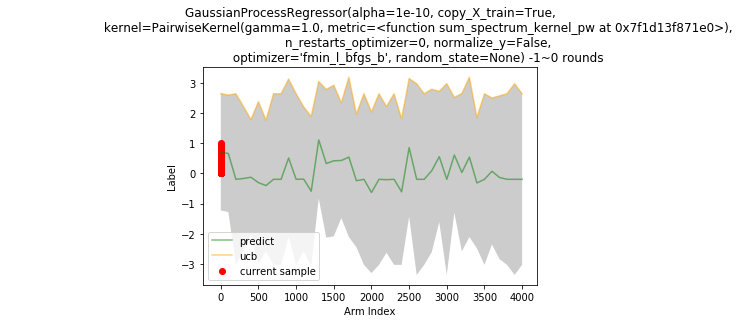

In [10]:
num_rounds = 1
num_exper = 1
num_rec = 60

my_env = Rewards_env(data, embedding)
new_env = Rewards_env(todesign_data, embedding)
if string_kernel_flag:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = PairwiseKernel(metric = kernel[-1])))
else:
    agent = GPUCB(new_env, num_rounds, init_list = my_env.rewards_dict, num_rec = num_rec,
              model = GaussianProcessRegressor(kernel = kernel[-1]))
rec_arms = agent.play(label_avaiable = False)

#### Sanity test of idx consistency

In [11]:
label_seqs = np.asarray(new_env.arm_features)[np.asarray(rec_arms)]
label_dict = {'0': 'A',
              '1': 'C',
              '2': 'G',
              '3': 'T'}

rbs_seqs = []

for seq in label_seqs:
    rbs_seq = []
    for i in range(int(len(seq))):
        start = i 
        end = start + 1
        s = seq[start:end]
        rbs_seq.append(label_dict[s])
    rbs_seq = ''.join(rbs_seq)
    rbs_seqs.append(rbs_seq)

for i in range(len(rec_arms)):
    assert rbs_seqs[i] == todesign_data[rec_arms[i], 0] 
    
print('Recommned index is consistent of the todesign_data index.')

Recommned index is consistent of the todesign_data index.


### Convert to RBS seq

In [12]:
todesign_data[np.asarray(rec_arms),0]

array(['TTTAAGACCCGGATATACAT', 'TTTAAGACGGATATATACAT',
       'TTTAAGACTCGGATATACAT', 'TTTAAGAATCGGATATACAT',
       'TTTAAGAACCGGATATACAT', 'TTTAAGATCGGATTATACAT',
       'TTTAAGATTCGGATATACAT', 'TTTAAGATCCGGATATACAT',
       'TTTAAGACGGATGTATACAT', 'TTTAAGACGGATCTATACAT',
       'TTTAAGAGTCGGATATACAT', 'TTTAAGAGCCGGATATACAT',
       'TTTAAGACGGATTTATACAT', 'TTTAAGATAAGGATATACAT',
       'TTTAAGACGATAATATACAT', 'TTTAAGAGGTCGATATACAT',
       'TTTAAGAGTAAGATATACAT', 'TTTAAGAGGTAGATATACAT',
       'TTTAAGATAAAGATATACAT', 'TTTAAGATAAGATTATACAT',
       'TTTAAGACTAAGATATACAT', 'TTTAAGAATAAGATATACAT',
       'TTTAAGATTAAGATATACAT', 'TTTAAGAGGGGGATATACAT',
       'TTTAAGAGGAAGATATACAT', 'TTTAAGAGGGGATTATACAT',
       'TTTAAGAGGGATTTATACAT', 'TTTAAGAGGGATCTATACAT',
       'TTTAAGAGGGATGTATACAT', 'TTTAAGAGGGATATATACAT',
       'TTTAAGACCCCGATATACAT', 'TTTAAGATTTTTATATACAT',
       'TTTAAGATTTTTGTATACAT', 'TTTAAGAGTTTTTTATACAT',
       'TTTAAGACTTTTTTATACAT', 'TTTAAGACCCCCTTATACAT',
       'TT

### Plot kernel matrix 

In [13]:
# use 6-base seuqence for kernel matrix
all_data = np.concatenate((data6, todesign6_data))
all_env = Rewards_env(all_data, embedding)
if len(kernel) == 1:
    kernel_matrix = kernel[0].__call__(all_env.embedded)
else:
    kernel_matrix = kernel[0](all_data[:,0])

In [14]:
kernel_matrix

array([[ 4,  1,  3, ...,  0,  0,  0],
       [ 1,  4,  3, ...,  0,  0,  0],
       [ 3,  3,  6, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 10,  9, 12],
       [ 0,  0,  0, ...,  9, 10, 12],
       [ 0,  0,  0, ..., 12, 12, 16]])

Text(0.5, 1.0, 'dotproduct kernel')

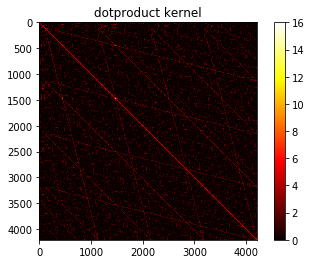

In [15]:
plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
#plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('dotproduct kernel')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

In [16]:
new_kernel_matrix = kernel_matrix[113:, 113:]

## Similarity Test

We expect that for similar arms, the predictor gives similar predictions. The above plot cannot show the similarity relationship between arm. So we design several experiments to show the similarity between arms and corresponding predictions. 

#### The goals are two folds: 
1. Understand how well the predictor works by showing the predictions for arms with similarity information. A good predictor should be able to predict similar labels for similar arms.
2. Explore the similarities of the recommended arms. If the top arms are similar to each other, then they are all from the same cluster, which is not a good way to suggest 60 arms. If they form 5-6 clusters, then this means you will see blocks in the kernel matrix, which is good.

#### The ways to explore similarities:  

A. sort the arm indexes in terms of the 
- A1) predictions (mu) 
- A2) the UCB (mu + sigma)
- A3) the confidence width (sigma)
respectively, then sort the kernel matrix in the same order. Then we can analyze for similar scores (A1), whether the arms have high similarities. Furthermore, we can analyze the similarities for recommended arms (A2 with top 60). 

B. Using the distance (l2 norm) between every single point to the average one as x-axis, the difference between labels of every point to the averaged label as the y-axis. Then sorted the arm based on the distance of arms, then we expect the higher than the distance of arms, the higher the difference between labels.

C. Using PCA to project the similarity matrix into one/two dimensions. Then use the weight as the x-axis and the corresponding label as the y-axis. Sorted based on the x-axis. Similarly, we expected the neighboring arms have similar labels.

D. Calculate the determinant for the kernel matrix, which reflects the volume of arms. The lower the volume, the higher the similarities. 

### A. sorting by labels

#### A1. sorting by mu

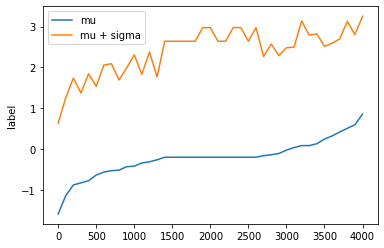

In [17]:
sorted_idx = np.asarray(sorted(range(len(agent.mu)), key=lambda k: (agent.mu)[k]))
plt.plot(range(len(agent.mu))[::100], agent.mu[sorted_idx][::100], label = 'mu')
plt.plot(range(len(agent.mu))[::100], (agent.mu + agent.sigma)[sorted_idx][::100], label = 'mu + sigma')
plt.ylabel('label')
#plt.xlim([3800,4096])
plt.legend()

Text(0.5, 1.0, 'dotproduct sorted kernel')

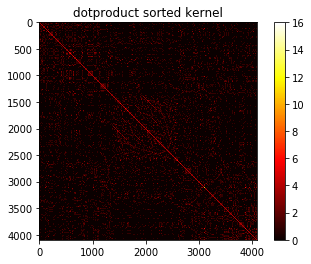

In [18]:
sorted_new_kernel_matrix = new_kernel_matrix[sorted_idx, :][:, sorted_idx]
plt.imshow(sorted_new_kernel_matrix, cmap = 'hot')
plt.colorbar()
plt.title('dotproduct sorted kernel')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

Text(0.5, 1.0, 'dotproduct sorted kernel Top 60')

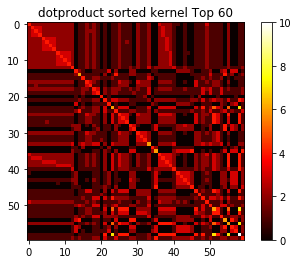

In [19]:
plt.imshow(sorted_new_kernel_matrix[-60:, -60:], cmap = 'hot')
plt.colorbar()
plt.title('dotproduct sorted kernel Top 60')
#plt.savefig('../plots/dotproduct_sorted_kernel.png')

#### A2. sorting by ucb (mu + sigma)

In [20]:
sorted_idx = np.asarray(sorted(range(len(agent.mu + agent.sigma)), key=lambda k: (agent.mu + agent.sigma)[k]))

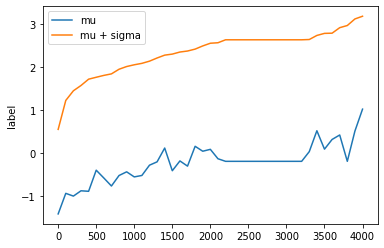

In [21]:
plt.plot(range(len(agent.mu))[::100], agent.mu[sorted_idx][::100], label = 'mu')
plt.plot(range(len(agent.mu))[::100], (agent.mu + agent.sigma)[sorted_idx][::100], label = 'mu + sigma')
plt.ylabel('label')
#plt.xlim([3800,4096])
plt.legend()

Text(0.5, 1.0, 'dotproduct sorted rec kernel Top 60')

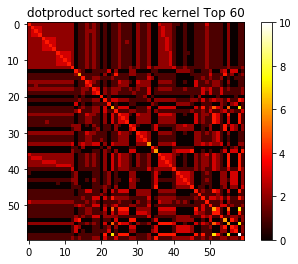

In [22]:
#plt.imshow(kernel_matrix, cmap = 'hot', interpolation='nearest')
plt.imshow(sorted_new_kernel_matrix[-60:,-60:], cmap = 'hot')
plt.colorbar()
plt.title('dotproduct sorted rec kernel Top 60')
#plt.savefig('../plots/dotproduct_sorted_rec_kernel.png')

### B. Soring by distance to center one

In [23]:
distances = []
center = np.mean(kernel_matrix, axis = 0)
for i, row in enumerate(kernel_matrix):
    distance = np.linalg.norm(row - center) ** 2/ len(row)
    distances.append(distance)

In [24]:
sorted_idx = np.asarray(sorted(range(len(distances)), key=lambda k: (distances)[k]))

sorted_distances = np.asarray(distances)[np.asarray(sorted_idx)]

labels = list(data[:, 1])+ list(agent.mu)
sorted_labels = np.asarray(labels)[np.asarray(sorted_idx)]

Text(0, 0.5, '|labels - mean|')

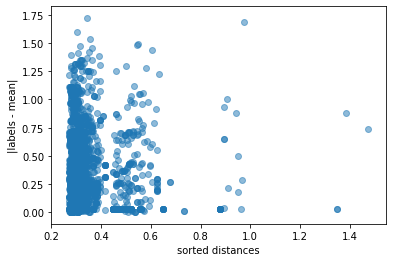

In [25]:
plt.scatter(sorted_distances, abs(sorted_labels - np.mean(labels)), alpha = 0.5)
plt.xlabel('sorted distances')
plt.ylabel('|labels - mean|')

#### A3. sorting by PCA weights

In [26]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
embedded = pca.fit_transform(kernel_matrix)
embedded.shape

(4209, 1)

Text(0.5, 1.0, 'Sort by PCA')

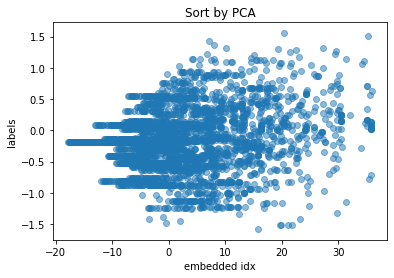

In [27]:
plt.scatter(embedded, labels, alpha = 0.5)
plt.xlabel('embedded idx')
plt.ylabel('labels')
plt.title('Sort by PCA')

#### A.4 Determinant

In [28]:
np.linalg.det(kernel_matrix[-60:, -60:])

16.000000000000497

### Save into file

In [30]:
import pickle

with open('sum_spectrum.pickle', 'wb') as handle:
    pickle.dump((agent, kernel_matrix, embedded, all_data), handle, protocol=pickle.HIGHEST_PROTOCOL)